# Visualization using MNIST Dataset (Assignment)

1. Visualize image data
2. Make your own loss plot
3. Generate a heatmap of confusion matrix

## Import dependencies

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model
from torch.autograd import Variable 
from torch.utils import data

from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if torch.cuda.is_available:
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST dataset

In [3]:
def MNIST_DATA(root='./', train=True, transforms=None, download=True, batch_size=32, num_worker=1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(),
                                    download=download)
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download=download)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [4]:
# If the download fails, you can try the following code. 
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz
trainDset,testDset,trainDataLoader,testDataLoader = MNIST_DATA(batch_size = 32, download = True)  # Data Loader 

[+] Get the MNIST DATA


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

[+] Finished loading data & Preprocessing


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(len(trainDataLoader))
print(len(testDataLoader))

1875
313


## TASK 1: Visualize MNIST dataset

matplotlib 혹은 seaborn 라이브러리를 이용해서 train dataset과 test dataset에 있는 MNIST 이미지 데이터를 시각화 해보세요!

Requirements:
- subplot을 사용하여 첫번째 row에는 train 이미지 10장, 두번째 row에는 test 이미지 10장 이어야 함.
- 모든 이미지는 grayscale 이미지로 변환.
- xticks 와 yticks 제거.


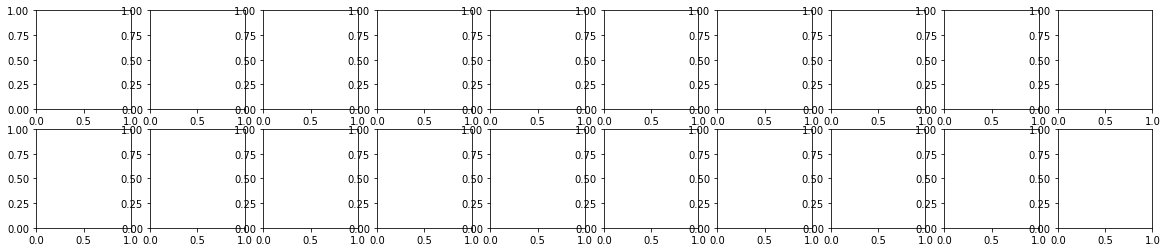

In [21]:
#################################
# TODO: Visualize image dataset #
#################################
def show_mnist():
    fig, axes = plt.subplots(2, 10, figsize=(20,4))

    # TODO
    
    fig.savefig('task1_sampled_images.png')

show_mnist()

## Our Neural Network Model: 3-layer Feed-Forward Network

In [7]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [8]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        train_losses, eval_losses = [], []
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0
            running_loss_eval = 0.0
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 500 mini-batches
                    train_losses.append(running_loss / 500)

                    # print evaluation loss at this time of training
                    # we're using test dataset for convenience, but you should *never* use test set here in practice.
                    self.net.eval()
                    with torch.no_grad():
                        for inputs, labels in self.testloader:
                            inputs = inputs.cuda()
                            labels = labels.cuda() 
                            outputs = self.net(inputs)
                            eval_loss = self.criterion(outputs, labels)
                            running_loss_eval += eval_loss.item()
                    eval_losses.append(running_loss_eval / len(self.testloader))

                    print('[%d, %5d] train loss: %.3f   eval loss: %.3f' % (e + 1, i + 1, running_loss / 500, running_loss_eval / len(self.testloader)))
                    running_loss = 0.0
                    running_loss_eval = 0.0

        print('Finished Training')
        return train_losses, eval_losses
        
    def test(self):
        self.net.eval()
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
                
    def generate_cf_matrix(self):
        self.net.eval()
        y_pred, y_true = [], []
        
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(pred)
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

        cf_matrix = confusion_matrix(y_true, y_pred)
        return cf_matrix


In [9]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [10]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [11]:
train_losses, eval_losses = trainer.train(epoch = 4)

[1,   500] train loss: 0.653   eval loss: 0.311
[1,  1000] train loss: 0.295   eval loss: 0.249
[1,  1500] train loss: 0.247   eval loss: 0.218
[2,   500] train loss: 0.187   eval loss: 0.184
[2,  1000] train loss: 0.179   eval loss: 0.175
[2,  1500] train loss: 0.165   eval loss: 0.153
[3,   500] train loss: 0.132   eval loss: 0.138
[3,  1000] train loss: 0.125   eval loss: 0.128
[3,  1500] train loss: 0.126   eval loss: 0.120
[4,   500] train loss: 0.109   eval loss: 0.121
[4,  1000] train loss: 0.101   eval loss: 0.110
[4,  1500] train loss: 0.098   eval loss: 0.109
Finished Training


In [12]:
trainer.test()


Test set:  Accuracy: 9694/10000 (97%)



## TASK 2: Make your own loss plot

Requirements:
- Train 과 evaluation loss plot은 같은 plot에 있어야 함.
- 나중에 이 함수는 써먹을 곳이 많으니 자유롭게 멋있게 만들어 주세요.

In [14]:
#################################
# TODO: Make your own loss plot #
#################################
def plot_losses(train_losses, eval_losses):
    iterations = np.arange(500, 500*(len(train_losses)+1), 500)
    plt.figure(figsize=(7,7))
    # TODO
    plt.savefig("task2_losses.png")

plot_losses(train_losses, eval_losses)

<Figure size 504x504 with 0 Axes>

In [15]:
cf_matrix = trainer.generate_cf_matrix()
cf_matrix

array([[ 970,    0,    0,    1,    1,    1,    1,    2,    3,    1],
       [   0, 1116,    5,    2,    0,    1,    2,    1,    8,    0],
       [  11,    1,  985,    3,    3,    0,    3,   11,   15,    0],
       [   1,    0,    6,  979,    0,    1,    1,    9,   13,    0],
       [   1,    0,    3,    0,  946,    0,    4,    5,    2,   21],
       [   3,    0,    0,   15,    1,  848,   10,    3,    9,    3],
       [   7,    1,    0,    1,    2,    2,  934,    1,   10,    0],
       [   1,    4,   11,    4,    0,    0,    0, 1000,    2,    6],
       [   5,    0,    1,    1,    3,    5,    2,    5,  949,    3],
       [   5,    4,    0,    6,    5,    2,    0,   11,    9,  967]])

In [16]:
# constant for classes
classes = ('0','1','2','3','4','5','6','7','8','9')
# convert to dataframe
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

df_cm

,0,1,2,3,4,5,6,7,8,9
0,970,0,0,1,1,1,1,2,3,1
1,0,1116,5,2,0,1,2,1,8,0
2,11,1,985,3,3,0,3,11,15,0
3,1,0,6,979,0,1,1,9,13,0
4,1,0,3,0,946,0,4,5,2,21
5,3,0,0,15,1,848,10,3,9,3
6,7,1,0,1,2,2,934,1,10,0
7,1,4,11,4,0,0,0,1000,2,6
8,5,0,1,1,3,5,2,5,949,3
9,5,4,0,6,5,2,0,11,9,967


## Task 3: Generate a heatmap of confusion matrix

seaborn library를 사용하여 confusion matrix의 heatmap을 구해보세요.

In [17]:
################################################
# TODO: Generate a heatmap of confusion matrix #
################################################
def visualize_cf_matrix(df_cm):
    plt.figure(figsize = (12,7))
    #TODO
    plt.savefig('task3_cf_matrix.png')

visualize_cf_matrix(df_cm)

<Figure size 864x504 with 0 Axes>